In [2]:
# Import necessary libraries
#Importing Librairies

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import os.path

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf



In [3]:
!pip install opendatasets
!pip install pandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import opendatasets as od
import pandas
  
od.download(
    "https://www.kaggle.com/datasets/grassknoted/asl-alphabet?resource=download")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sanyaver
Your Kaggle Key: ··········


100%|██████████| 1.03G/1.03G [00:43<00:00, 25.2MB/s]


In [5]:
!ls

asl-alphabet  sample_data


In [6]:
!ls asl-alphabet/asl_alphabet_test/asl_alphabet_test

A_test.jpg  G_test.jpg	M_test.jpg	  R_test.jpg	  W_test.jpg
B_test.jpg  H_test.jpg	nothing_test.jpg  space_test.jpg  X_test.jpg
C_test.jpg  I_test.jpg	N_test.jpg	  S_test.jpg	  Y_test.jpg
D_test.jpg  J_test.jpg	O_test.jpg	  T_test.jpg	  Z_test.jpg
E_test.jpg  K_test.jpg	P_test.jpg	  U_test.jpg
F_test.jpg  L_test.jpg	Q_test.jpg	  V_test.jpg


In [7]:
# Define helper functions

# Convert folder to dataframe of images' paths & labels
def get_paths_labels(path, allowed_extension="jpg"):
        global Path
        images_dir = Path(path)
        
        filepaths = pd.Series((images_dir.glob(fr'**/*.{allowed_extension}'))).astype(str)
        filepaths.name = "path"
        
        labels = filepaths.str.split("/")[:].str[-2]
        labels.name = "label"

        # Concatenate filepaths and labels
        df = pd.concat([filepaths, labels], axis=1)

        # Shuffle the DataFrame and reset index
        df = df.sample(frac=1).reset_index(drop = True)
        return df


In [8]:
# Read image
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


In [9]:
# Visualize samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    images = filepaths.apply(get_image).reset_index(drop=True)
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()


In [10]:
# Process image (input) for the model
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img


# Make classifications & visualize results
def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    
    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])
    
    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_true = labels
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"Y true({y_true[sample_index]}) | Y pred ({y_pred[sample_index]})")
            ax[i,j].set_axis_off()
    plt.show()


In [13]:
# Read datasets

# Create dataframe of {paths, labels}
train_df = get_paths_labels('asl-alphabet/asl_alphabet_train/asl_alphabet_train')

# Import another dataset (to train model on various data)
temp_df = get_paths_labels('asl-alphabet-test')

# Combine both datasets
dataset = pd.concat((train_df, temp_df))


In [14]:
# Classes counts
print("Classes counts")
counts = dataset.iloc[:,1].value_counts().sort_index()
print(counts.head(counts.shape[0]))
print(f"\n\nDataset size = {counts.sum()} samples")


Classes counts
A          3000
B          3000
C          3000
D          3000
E          3000
F          3000
G          3000
H          3000
I          3000
J          3000
K          3000
L          3000
M          3000
N          3000
O          3000
P          3000
Q          3000
R          3000
S          3000
T          3000
U          3000
V          3000
W          3000
X          3000
Y          3000
Z          3000
del        3000
nothing    3000
space      3000
Name: label, dtype: int64


Dataset size = 87000 samples


In [15]:
# Preprocess data

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    validation_split=0.2,
    horizontal_flip = True,
    brightness_range=(0.75, 1.3),
    zoom_range=0.2
)


train_images = train_generator.flow_from_dataframe(
    dataframe=dataset,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataset,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='validation'
)


Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.


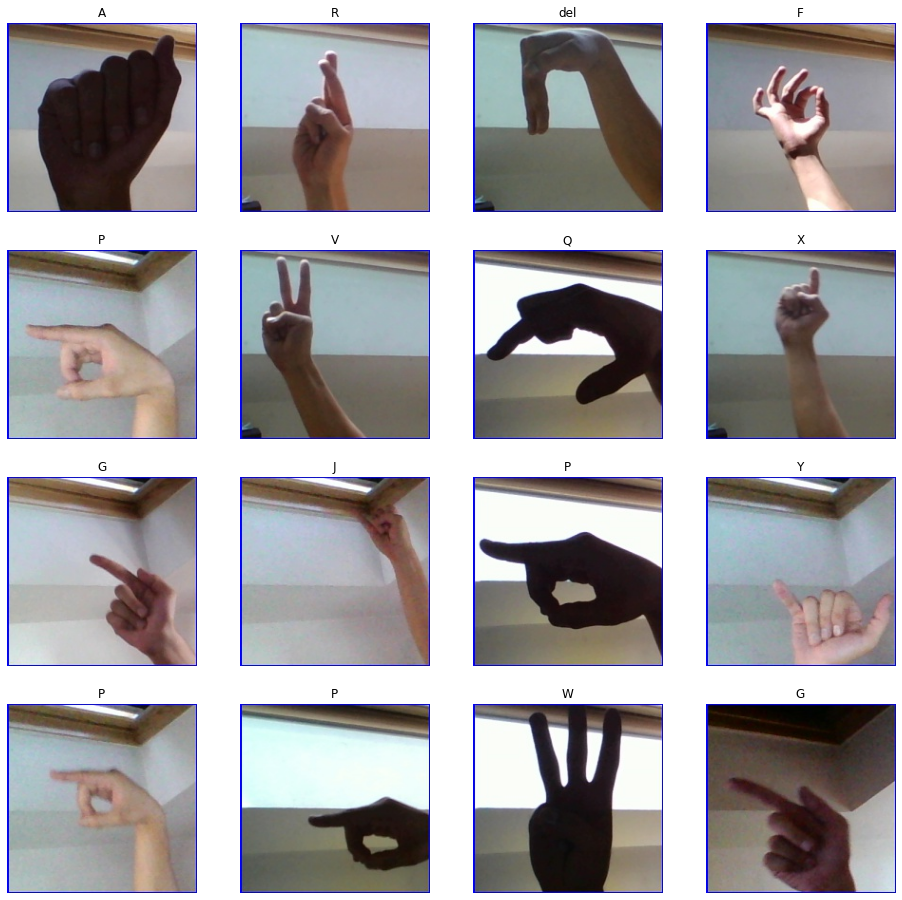

In [16]:
visualize_samples(train_images)


In [17]:
# Neural network architecture

pretrainedModel = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.005)


17225924/17225924 [==============================] - 1s 0us/step


In [18]:
# Compile model
model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [19]:
# Fit model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=2,
 )


Epoch 1/2
1088/1088 [==============================] - 4021s 4s/step - loss: 0.2482 - accuracy: 0.9206 - val_loss: 0.1012 - val_accuracy: 0.9668
Epoch 2/2
1088/1088 [==============================] - 3989s 4s/step - loss: 0.1042 - accuracy: 0.9667 - val_loss: 0.0668 - val_accuracy: 0.9783


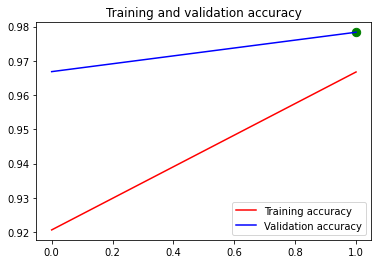

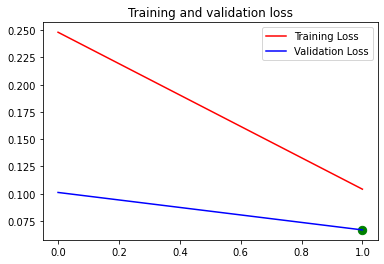

In [20]:
# Training & Validation <> Loss & Accuracy

%matplotlib inline
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs = np.arange(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.scatter(epochs[val_acc.argmax()], val_acc.max(), color='green', s=70)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.scatter(epochs[val_loss.argmin()], val_loss.min(), color='green', s=70)
plt.title('Training and validation loss')
plt.legend()

plt.show()


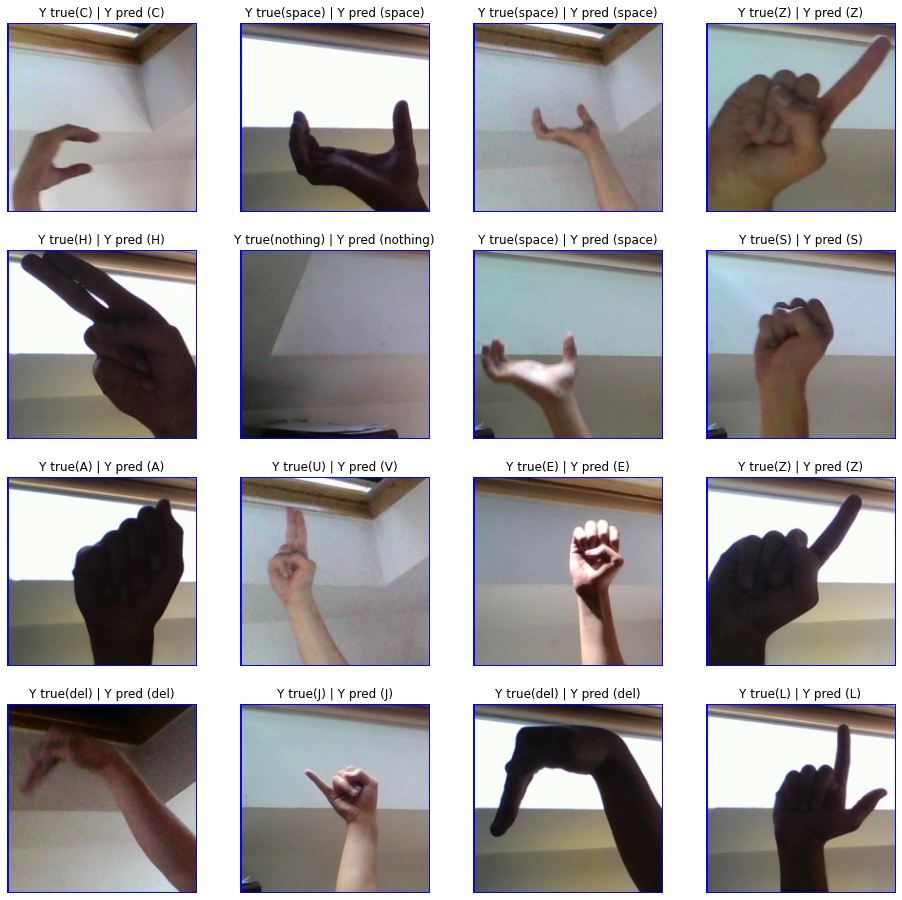

In [22]:
# Visualize classifications on validation set
visualize_classifications(model, val_images)